<a id="top"></a>
# Beginner: Searching MAST using astroquery.mast

## Introduction and Goals:
This is a beginner tutorial on accessing the [MAST Archive](https://archive.stsci.edu) using the [Astroquery API](https://astroquery.readthedocs.io/en/latest/mast/mast.html). We'll cover the major search features you might find useful when querying for observations. By the end of this tutorial, you will:

* Understand how to search for observations hosted on the MAST Archive
* Download data products corresponding to your observations of interest
* Create a visual display of the downloaded data

## Table of Contents

* [Imports](#Imports)
* [Three ways to search for MAST observations](#Three-Ways-to-Search-for-MAST-Observations)
    - [By Region](#1.-By-Region)
    - [By Object Name](#2.-By-Object-Name)
    - [By Criteria](#crit)
* [Getting Associated Data Products](#Getting-Associated-Data-Products)
    - [Performing a Product Query](#Performing-a-Product-Query)
    - [Filtering Data Products](#Filtering-the-Data-Products)
* [Downloading Products](#Downloading-Products)
* [Displaying Data](#Displaying-Data)
* [Further Reading](#Further-Reading)

## Imports

Let's start by importing the packages we need for this notebook.

* `astroquery.mast` to access the MAST API
* `astropy` to create [coordinate objects](https://docs.astropy.org/en/stable/coordinates/index.html) and read fits files
* `matplotlib` to plot the data

In [1]:
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.mast import Observations
from matplotlib.colors import SymLogNorm

import matplotlib.pyplot as plt

%matplotlib inline

## Three Methods to Search for MAST Observations

All three searches outlined below use [`astroquery.mast`](https://astroquery.readthedocs.io/en/latest/mast/mast.html), an astronomer-friendly wrapper for [our pure Python API](https://mast.stsci.edu/api/v0/). Specifically, these searches use the [Observations](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html) class, which queries our entire multi-mission collection.

### 1. Query by Region
To search by coordinates (and a radius), you can use `Observations.query_region`. The coordinates can be given as a string or `astropy.coordinates` object; the radius, as a string or float. If no radius is specified, the default is 0.2 degrees.

Let's try an example search with the coordinates `[290.213503, -11.800746]` (arbitrarily chosen) and no radius.

In [2]:
# This will give a warning that the coordinates are being interpreted as an ICRS coordinate provided in degrees
obsByRegion = Observations.query_region("290.213503 -11.800746")
len(obsByRegion)

517

Excellent! At the time of writing, this search returns 358 results. As the MAST archive grows, this number increases; you might see a larger value. Let's take a look a subset of the results.

In [3]:
# Preview the first 3 results
obsByRegion[:3]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,distance
str7,str5,str9,str13,str4,str4,str16,str18,str4,str78,float64,float64,str10,str19,int64,float64,float64,float64,float64,float64,str63,float64,str6,str3,int64,str116,str120,str116,str6,bool,float64,str9,float64
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0054-1-3,293.1472936457296,-9.71249801098487,image,"Ricker, George",3,59769.40067108796,59795.62954313657,475.199781,600.0,1000.0,--,59828.0,N/A,--,54,POLYGON 288.297067 -16.349772 285.946199 -5.101134 297.968471 -2.757443 300.386369 -14.421799 288.297067 -16.349772,--,--,PUBLIC,False,nan,92616850,0.0
science,TESS,SPOC,Photometer,TESS,TESS,Optical,TESS FFI,--,tess-s0080-1-4,285.6629279299061,-9.094913113849628,image,"Ricker, George",3,60479.387118125,60505.84107659722,158.399925,600.0,1000.0,--,60545.0,N/A,--,80,POLYGON 280.09193 -15.630142 279.064881 -3.763278 291.262336 -2.663712 292.216134 -14.120328 280.09193 -15.630142,--,--,PUBLIC,False,nan,229777516,0.0
science,TESS,SPOC,Photometer,TESS,TESS,OPTICAL,TESS FFI,--,tess-s0092-2-3,292.2523797657134,-14.960342033807292,image,"Ricker, George",3,60802.46739517361,60829.14535021991,158.399926,600.0,1000.0,--,60837.0,N/A,--,92,POLYGON 285.626204 -10.005632 297.052833 -7.876302 299.451098 -19.879023 286.870885 -21.759304 285.626204 -10.005632,--,--,PUBLIC,False,nan,266380141,0.0


The columns of the above table (there are many!) correspond to [searchable fields in the MAST database](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html). You can find an example of performing a search by criteria [down below](#crit).

To avoid that pesky warning from the search above, we can create a `coordinates` object and pass it to our query. Let's try that now, and in addition, add a radius of 1 arcsecond to this search.

In [4]:
# Set up our coordinates object
coord = SkyCoord(290.213503, -11.800746, unit='deg')

# Same search as above, now with a radius of 1 arcsecond
obsByRegion2 = Observations.query_region(coord, radius='1s')
len(obsByRegion2)

13

**Consistency check**: we expect that as the radius gets smaller, we will get fewer results. In this case, only 11 results are returned compared to 358 above.

Let's take a look at the results again, this time limiting the displayed columns.

In [5]:
# Let's limit the number of columns we see at once
columns = ['obs_collection', 'intentType', 'instrument_name', 
           'target_name', 't_exptime', 'filters', 'dataproduct_type']

# Show the results with the above columns only
obsByRegion2[columns]

obs_collection,intentType,instrument_name,target_name,t_exptime,filters,dataproduct_type
str5,str7,str10,str12,float64,str4,str5
TESS,science,Photometer,TESS FFI,475.199781,TESS,image
TESS,science,Photometer,TESS FFI,158.399925,TESS,image
TESS,science,Photometer,TESS FFI,158.399926,TESS,image
PS1,science,GPC1,1126.007,731.0,g,image
PS1,science,GPC1,1126.007,900.0,i,image
PS1,science,GPC1,1126.007,876.0,r,image
PS1,science,GPC1,1126.007,580.0,y,image
PS1,science,GPC1,1126.007,480.0,z,image
HLSP,science,Photometer,TICA FFI,475.2,TESS,image


This "streamlined" view is helpful: it avoids visual clutter and helps you to focus on the fields that are most relevant to your search.

### 2. Query by Object Name

To search for an object by name, you can use the `query.object()` function. As before, you may optionally specify a radius.

The object name is first resolved to coordinates by a call to the [Simbad](https://simbad.unistra.fr/simbad/) and [NED](https://ned.ipac.caltech.edu/Documents/Overview) archives. Then, the search proceeeds based on these coordinates.

In [6]:
obsByName = Observations.query_object("M51", radius=".005 deg")

# print total number of results; then show only the first five
print("Number of results:", len(obsByName))
obsByName[columns][:5]

Number of results: 1226


obs_collection,intentType,instrument_name,target_name,t_exptime,filters,dataproduct_type
str5,str11,str12,str64,float64,str26,str10
TESS,science,Photometer,TESS FFI,1425.599358,TESS,image
TESS,science,Photometer,TESS FFI,1425.599393,TESS,image
TESS,science,Photometer,TESS FFI,1425.599383,TESS,image
TESS,science,Photometer,TESS FFI,475.199787,TESS,image
TESS,science,Photometer,TESS FFI,158.399923,TESS,image


For some special catalogs, like those used with Kepler, K2, and TESS, `astroquery` performs a direct lookup using the MAST catalog. It is important to include both the **_catalog identifier_** and number when searching one of these datasets; for example, to query the TESS Input catalog you would use `"TIC 261136679"`, rather than a plain `"261136679"`.

In [7]:
obsByTessName = Observations.query_object("TIC 261136679", radius="1s")

# we'll use some new columns to de-clutter the table
columns = ['obs_collection', 'wavelength_region', 'provenance_name', 't_min', 't_max', 'obsid']

# print number of results and display the first five
print("Number of results:", len(obsByTessName))
obsByTessName[columns][:5]

Number of results: 169


obs_collection,wavelength_region,provenance_name,t_min,t_max,obsid
str5,str10,str17,float64,float64,str9
TESS,Optical,SPOC,58324.81304390046,58352.666903854166,60865631
TESS,Optical,SPOC,58410.41593530092,58436.33232072917,61132377
TESS,Optical,SPOC,58516.85312458334,58541.49921487269,62468248
TESS,Optical,SPOC,58596.27096596065,58623.37541814815,65153352
TESS,Optical,SPOC,58624.45954434028,58652.37651001157,65180725


It's worth noting that even though we queried using the TESS Input Catalog, not all of the results are from the TESS mission.  In fact, we can see exactly which missions are returned using Python's built-in `set` function:

In [8]:
# return the unique set of missions found in this query
set(obsByTessName['obs_collection'])

{'GALEX', 'HLSP', 'SWIFT', 'TESS'}

The TIC is a catalog like any other, and the MAST Archive resolves the input name to a location on the sky. Other missions that have observed the same region will also return results.

To search for results that are specific to TESS, or your mission of choice, see the 'by other criteria' section below.

### 3. Query by Other Criteria (with or without name/region) <a id="crit"></a>

To search for observations based on additonal parameters, you can use `query_criteria()`. In a sense, this is a more powerful version of the tools above, as you can still search by coordinates and objectname; however, you can inculde additional desired criteria. You may also run the search without specifying a name or coordinates.

To perform the search, give your critera as keyword arguments. There are many [valid criteria for MAST searches](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html) . (Note that these are columns of the results tables we saw above!) Some relevant examples are: "filters", "t_exptime" (exposure time), instrument_name, "provenance_name", and "sequence_number". 

Let's query for TESS Sector 9 data with an exposure time between 1400 and 1500s.

In [9]:
obsByCriteria = Observations.query_criteria(obs_collection=["TESS"], sequence_number=9,
                                            t_exptime=[1400, 1500])

columns = ['target_name', 's_ra', 's_dec', 't_exptime', 'obsid']
obsByCriteria[columns][:5]

target_name,s_ra,s_dec,t_exptime,obsid
str8,float64,float64,float64,str8
TESS FFI,169.0707180032819,-21.387226979894706,1425.599414,62891912
TESS FFI,157.48628713094715,-43.22571855614874,1425.599414,62894034
TESS FFI,143.74057778883315,-36.89051396313313,1425.599414,62893522
TESS FFI,72.28880568223647,-72.70228936448599,1425.599414,62899417
TESS FFI,135.13107661187195,-63.35224663118256,1425.599414,62897231


There's no limit on the number of filters you can apply in a search. It may be an interesting exercise for the reader to go through the example below and figure out what exactly we're searching for.

(Hint: check the [field descriptions](https://mast.stsci.edu/api/v0/_c_a_o_mfields.html))

In [10]:
# Make sure to run this cell, as the data is used in the sections that follow

exByCriteria = Observations.query_criteria(obs_collection=["HLA"], s_dec=[50, 60], 
                                           calib_level=[3], proposal_pi="Mould*", 
                                           dataproduct_type="IMAGE", t_max=[49800, 49820])

columns = ['obs_collection', 'obs_id', 'target_name', 'filters', 'instrument_name', 'proposal_id']
exByCriteria[columns]

obs_collection,obs_id,target_name,filters,instrument_name,proposal_id
str3,str27,str12,str9,str9,str4
HLA,hst_05766_04_wfpc2_f555w_pc,NGC5457-FLD2,F555W,WFPC2/PC,5766
HLA,hst_05766_04_wfpc2_f555w_wf,NGC5457-FLD2,F555W,WFPC2/WFC,5766
HLA,hst_05766_04_wfpc2_total_pc,NGC5457-FLD2,DETECTION,WFPC2/PC,5766
HLA,hst_05766_04_wfpc2_total_wf,NGC5457-FLD2,DETECTION,WFPC2/WFC,5766


## Getting Associated Data Products

Each observation returned from a MAST query can have one or more associated data products. For example, a JWST observation might return an [uncalibrated file](https://outerspace.stsci.edu/display/MASTDOCS/Supplemental+Products), [a guide-star file](https://jwst-docs.stsci.edu/jwst-observatory-characteristics-and-performance/jwst-pointing-performance/jwst-guide-stars), and the science data you're searching for.

### Performing a Product Query


Using an astropy table of observations, or a list of observation ids ("obs_ids"), `get_product_list()` will return a table containing the associated data products.

Since we already have a list of observations, we can use that as the starting point for our query. To keep it simple, let's look at only the last observation from our search above.

In [11]:
# Let's select a small subset from our critera search above
newObsList = exByCriteria[-1:]

# Now we get the list of products associated with that observation
dataProducts = Observations.get_product_list(newObsList)

# preview the first five
dataProducts[:5]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str30,str67,str1,str96,str9,str28,str8,str1,str8,str19,str4,str43,int64,str8,str6,int64,str9
25153181,HLA,image,hst_05766_04_wfpc2_f555w_wf_02,Preview-Full,S,mast:HLA/url/cgi-bin/preview.cgi?dataset=hst_05766_04_wfpc2_f555w_wf_02,PREVIEW,--,--,--,HLA,--,5766,hst_05766_04_wfpc2_f555w_wf_02_drz.jpg,--,25579950,PUBLIC,2,F555W
25153181,HLA,image,hst_05766_04_wfpc2_f555w_wf_02,HLA simple fits science image,S,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_05766_04_wfpc2_f555w_wf_02_drz.fits,SCIENCE,--,DRZ,--,HLA,--,5766,hst_05766_04_wfpc2_f555w_wf_02_drz.fits,10281600,25579950,PUBLIC,2,F555W
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,Preview-Full,C,mast:HLA/url/cgi-bin/preview.cgi?dataset=hst_05766_04_wfpc2_total_wf,PREVIEW,--,--,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_drz.jpg,--,25579950,PUBLIC,3,DETECTION
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,HLA DAOPHOT Catalog,C,mast:HLA/url/cgi-bin/getdata.cgi?download=1&filename=hst_05766_04_wfpc2_total_wf_daophot_trm.cat,SCIENCE,Minimum Recommended Products,DAOPHOT,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_daophot_trm.cat,--,25579950,PUBLIC,3,DETECTION
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_05766_04_wfpc2_total_wf_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_drz.fits,30798720,25579950,PUBLIC,3,DETECTION


### Filtering the Data Products

After the data products have been retrieved, you can use `filter_products` to download only data products that meet your given criteria. There are many [filters for MAST products](https://mast.stsci.edu/api/v0/_productsfields.html). Some examples are: `mrp_only` (Minimum Recommended Products) and `extension` (file extension).

A note on filtering: each listed filter is joined with an AND, but each option within that filter is joined with an OR. For example, the search below will return any products that are 'science' type **AND** have a calibration level of 2 **OR** 3.

In [12]:
scienceProducts = Observations.filter_products(dataProducts, productType=["SCIENCE"],
                                               calib_level=[2, 3], mrp_only=False)
scienceProducts[:5]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str3,str5,str30,str67,str1,str96,str9,str28,str8,str1,str8,str19,str4,str43,int64,str8,str6,int64,str9
25153181,HLA,image,hst_05766_04_wfpc2_f555w_wf_02,HLA simple fits science image,S,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_05766_04_wfpc2_f555w_wf_02_drz.fits,SCIENCE,--,DRZ,--,HLA,--,5766,hst_05766_04_wfpc2_f555w_wf_02_drz.fits,10281600,25579950,PUBLIC,2,F555W
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,HLA DAOPHOT Catalog,C,mast:HLA/url/cgi-bin/getdata.cgi?download=1&filename=hst_05766_04_wfpc2_total_wf_daophot_trm.cat,SCIENCE,Minimum Recommended Products,DAOPHOT,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_daophot_trm.cat,--,25579950,PUBLIC,3,DETECTION
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,HLA simple fits science image,C,mast:HLA/url/cgi-bin/getdata.cgi?dataset=hst_05766_04_wfpc2_total_wf_drz.fits,SCIENCE,Minimum Recommended Products,DRZ,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_drz.fits,30798720,25579950,PUBLIC,3,DETECTION
25579950,HLA,image,hst_05766_04_wfpc2_total_wf,HLA SExtractor Catalog,C,mast:HLA/url/cgi-bin/getdata.cgi?download=1&filename=hst_05766_04_wfpc2_total_wf_sexphot_trm.cat,SCIENCE,Minimum Recommended Products,SEXPHOT,--,HLA,--,5766,hst_05766_04_wfpc2_total_wf_sexphot_trm.cat,--,25579950,PUBLIC,3,DETECTION
24556184,HST,image,u2ms0402t,DADS C0F file - Calibrated exposure WFPC/WFPC2/FOC/FOS/GHRS/HSP,S,mast:HST/product/u2ms0402t_c0f.fits,SCIENCE,--,C0F,--,CALWFPC2,"2.5.3 (Sep 4, 2008)",5766,u2ms0402t_c0f.fits,10307520,25579950,PUBLIC,2,F555W


## Downloading Products
Passing a table of products (like the one above) to `download_products()` will download the entire table. You can also pass a list of Observation IDs (obs_id) if you know them. `download_products()` also allows you to filter data as you request the download. In the example below, we will only download the drizzled files (`drz.fits`).

Products will, by default, be downloaded into the current working directory, in a subdirectory called `mastDownload.`The full local file paths will have the form `mastDownload/Mission/Observation ID/file`.

In [13]:
# This is the filtered download of the scienceProducts table
manifest = Observations.download_products(scienceProducts, extension=("drz.fits"))

# Uncomment below for "plain" download of the scienceProducts table
# manifest = Observations.download_products(scienceProducts)

INFO: Found cached file ./mastDownload/HLA/hst_05766_04_wfpc2_f555w_wf_02/hst_05766_04_wfpc2_f555w_wf_02_drz.fits with expected size 10281600. [astroquery.query]


INFO: Found cached file ./mastDownload/HLA/hst_05766_04_wfpc2_total_wf/hst_05766_04_wfpc2_total_wf_drz.fits with expected size 30798720. [astroquery.query]


Note: `download_products` includes caching by default. If you have downloaded the files before, they will not be downloaded again unless caching is turned off. This may cause issues if the data is updated and the filename remains the same!

In [14]:
manifest

Local Path,Status,Message,URL
str89,str8,object,object
./mastDownload/HLA/hst_05766_04_wfpc2_f555w_wf_02/hst_05766_04_wfpc2_f555w_wf_02_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_05766_04_wfpc2_total_wf/hst_05766_04_wfpc2_total_wf_drz.fits,COMPLETE,None,None


The manifest returns useful information about the status of the files. You can find the local path, along with a status. This will either be COMPLETE, SKIPPED, or ERROR. If the status is ERROR, there will be additional information in the 'Message' column. The URL field includes a link to directly download the data.

## Displaying Data

At this point the data is ready for analysis, and we are done querying the MAST Archive.

Below we take a look at the data files using `astropy.fits` and `matplotlib`.

In [15]:
# Get the filenames from the manifest
filename0 = manifest['Local Path'][0]
filename1 = manifest['Local Path'][1]

# Open the files using astropy.fits
file1 = fits.open(filename0)
file2 = fits.open(filename1)

With the files opened, we can create a plot:

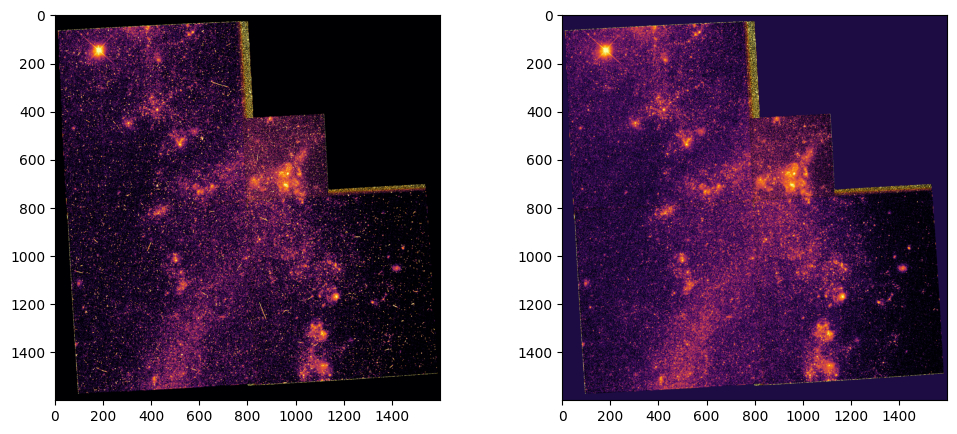

In [16]:
# initialize the plot
f, (ax1, ax2) = plt.subplots(1, 2)

# set height and width
f.set_figheight(5)
f.set_figwidth(12)

# plot the data
ax1.imshow(file1[0].data, cmap="inferno", norm=SymLogNorm(linthresh=0.03, vmin=0, vmax=1.5))
ax2.imshow(file2['SCI'].data, cmap="inferno", norm=SymLogNorm(linthresh=0.03, vmin=-0.01, vmax=1.5))

We've plotted the same region of the sky, with subtle differences caused by the differing filters.

## Further Reading
[astoquery.mast readthedocs](https://astroquery.readthedocs.io/en/latest/mast/mast.html)

## About this Notebook
For additonal questions, comments, or feedback, please email `archive@stsci.edu`. 

**Authors:** Thomas Dutkiewicz, Scott Fleming <br>
**Keywords:** MAST, astroquery <br>
**Latest update** Mar 2025 <br>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 